In [103]:
import numpy as np
import pandas as pd
import math
from math import log
from sklearn.metrics import accuracy_score
import re

In [104]:
data = {
    '年龄': ['青年', '青年', '青年', '青年', '青年', '中年', '中年', '中年', '中年', '中年', '老年', '老年', '老年', '老年', '老年'],
    '有工作': ['否', '否', '是', '是', '否', '否', '否', '是', '否', '否', '否', '否', '是', '是', '否'],
    '有房子': ['否', '否', '否', '是', '否', '否', '否', '是', '是', '是', '是', '是', '否', '否', '否'],
    '信用': ['一般', '好', '好', '一般', '一般', '一般', '好', '好', '非常好', '非常好', '非常好', '好', '好', '非常好', '一般'],
    '类别': ['否', '否', '是', '是', '否', '否', '否', '是', '是', '是', '是', '是', '是', '是', '否']
}

train_data = pd.DataFrame(data)  # 创建DataFrame数据

In [105]:

print(train_data)

    年龄 有工作 有房子   信用 类别
0   青年   否   否   一般  否
1   青年   否   否    好  否
2   青年   是   否    好  是
3   青年   是   是   一般  是
4   青年   否   否   一般  否
5   中年   否   否   一般  否
6   中年   否   否    好  否
7   中年   是   是    好  是
8   中年   否   是  非常好  是
9   中年   否   是  非常好  是
10  老年   否   是  非常好  是
11  老年   否   是    好  是
12  老年   是   否    好  是
13  老年   是   否  非常好  是
14  老年   否   否   一般  否


## 计算数据集的熵

$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$

其中，$H(D)$是数据集$D$的熵，$|C_k|$是$D$中属于第$k$类的样本个数，$K$是类的个数。

In [106]:
from collections import Counter

def calcEnt(y_label):
    num_samples = y_label.shape[0]
    cnt = Counter(y_label) ## return a dictionary
    ent = -sum([(p / num_samples) * log(p / num_samples, 2) for p in cnt.values()])
    return ent

## 计算给定某个特征属性后的条件熵

$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$

其中，$D_i$是$D$中特征$A$取第$i$个值的样本子集，$H(D_i)$是数据集$D_i$的熵，$H(D|A)$是数据集$D$对特征$A$的条件熵，$n$是特征$A$取 值的个数。$H(D_i)$的表达式如下：

$$H(D_i)=-\sum_{k=1}^{K} \frac{\left|C_{k}^i\right|}{|D_i|} \log _{2} \frac{\left|C_{k}^i\right|}{|D_i|}$$

其中$|D_i|$为属性A取第$i$个取值时的样本个数，$|C_{k}^i|$为样本集$D_i$中属于第$k$个类别的个数。

In [107]:
def condEnt(attri_data, y_label):
    num_samples = y_label.shape[0]
    attri_cnt = Counter(attri_data) ## return a dictionary
    cond_ent = 0
    for key in attri_cnt:
        attri_key_label = y_label[attri_data==key]
        cond_ent += len(attri_key_label)/num_samples * calcEnt(attri_key_label)
    return cond_ent


## 计算信息增益 

给定特征属性$A$后，信息增益$g(D, A)$定义为原有数据的信息熵H(D)减去条件信息熵H(D|A)

$$g(D, A)=H(D)-H(D|A)$$

## 选择特征属性

信息增益最大的属性被选择。

In [108]:
def OptAttri(train_data):
    infoGain =0 
    y_label = train_data.iloc[:,-1]
    attri_num = train_data.shape[1]-1
    for i in range (attri_num):
        attri_data = train_data.iloc[:,i]
        ent = calcEnt(y_label)
        cond_ent = condEnt(attri_data, y_label)
        infoGain_tmp = ent-cond_ent
        if infoGain_tmp > infoGain:
            infoGain = infoGain_tmp
            opt_attr_name = train_data.columns[i]
            opt_attr = i
    return opt_attr, opt_attr_name, infoGain
    

In [109]:
# opt_name, infG = OptAttri(train_data)
# print ('特征({})的信息增益最大，其值为({})，选择为根节点特征.'.format(opt_name,infG))

## 定义节点类

* 一个节点，应该包含节点的属性，节点标签，节点子属性，节点预测
* 若节点是根节点，则直接给节点属性和节点标签
* 若节点不是根节点，则需要对节点进行继续划分，需要构建树

In [110]:
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, attri_name=None):
        self.root = root ## 是否为根节点
        self.label = label ## 节点的标签
        self.attri_name = attri_name ## 节点的属性名字
        self.tree = {} ## 某个节点的子树
        self.result = {
            'label:': self.label,
            'attri_name':self.attri_name,
            'tree': self.tree,
            'root': self.root
        }

    def add_node(self, val, node): ## 根据属性的划分取值val，继续建立节点。
        self.tree[val] = node
    
    def __repr__(self):
        return '{}'.format(self.result)


In [111]:
from pydotplus import graphviz
import re
from IPython.display import display, Image

def tree2graph(i, g, root):
    if root.attri_name == None:
        g_node_label = f'Node:{i}\n属性:{root.attri_name}\n标签:{root.label}'
    else:
        g_node_label = f'Node:{i}\n属性:{root.attri_name}\n标签:{root.label}'
    g_node = i
    g.add_node(graphviz.Node(g_node, label=g_node_label, fontname='FangSong'))
    
    for val in list(root.tree):
        i, g_children = tree2graph(i+1, g, root.tree[val])
        g.add_edge(graphviz.Edge(g_node, g_children, label=val, fontname='FangSong'))
    return i, g_node

def draw(root):
    g = graphviz.Dot()
    tree2graph(0, g, root)
    g2 = graphviz.graph_from_dot_data(g.to_string())
    display(Image(g2.create_png()))

## 利用ID3算法建立decision tree

In [112]:
class ID3_DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    def calcEnt(self, y_label):
        num_samples = y_label.shape[0]
        cnt = Counter(y_label) ## return a dictionary
        ent = -sum([(p / num_samples) * log(p / num_samples, 2) for p in cnt.values()])
        return ent


    # 条件熵

    def condEnt(self, attri_data, y_label):
        num_samples = y_label.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        cond_ent = 0
        for key in attri_cnt:
            attri_key_label = y_label[attri_data==key]
            cond_ent += len(attri_key_label)/num_samples * self.calcEnt(attri_key_label)
        return cond_ent

    ## 特征属性选择

    def OptAttri(self,train_data):
        infoGain =0 
        y_label = train_data.iloc[:,-1]
        attri_num = train_data.shape[1]-1
        for i in range (attri_num):
            attri_data = train_data.iloc[:,i]
            ent = self.calcEnt(y_label)
            cond_ent = self.condEnt(attri_data, y_label)
            infoGain_tmp = ent-cond_ent
            if infoGain_tmp > infoGain:
                infoGain = infoGain_tmp
                opt_attr = train_data.columns[i] ## attri name
        return opt_attr, infoGain

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        y_label = train_data.iloc[:,-1]
        feature_space = train_data.columns[:-1] ## feature names
                                                                                
        features = train_data.iloc[:,:-1]
    
        # 1,若D中实例属于同一类Ck，即y_label 中的类别个数为1，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_label.value_counts()) == 1: 
            return Node(root=True, label=y_label.iloc[0])

        # 2, 若特征属性A为空，则T为单节点树，将D中样本数最多的类Ck作为该节点的类标记，返回T
        if len(feature_space) == 0:
            return Node(root=True,label=y_label.value_counts().sort_values(ascending=False).index[0])

        # 3,若不是上述情况，需要计算信息增益, 选择信息增益最大的属性做为待选根节点属性Ag
        opt_attr_name, max_infoGain= self.OptAttri(train_data)
        
        # 4,若Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是样本数最多的类Ck作为该节点的类标记，返回T
        if max_infoGain < self.epsilon:
            return Node(root=True,label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,若Ag的infogain大于阈值eta，则需要构建Ag子集
        node_tree = Node(root=False, attri_name=opt_attr_name)
        feature_list = train_data[opt_attr_name].value_counts().index ## 已选属性的子属性的名称
       
         ## 需要确定每个子属性下面的样本子集，并且根据其他属性对样本子集继续进行树的划分 （去除根属性）
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[opt_attr_name] ==f].drop([opt_attr_name], axis=1)

         # 6, 递归生成树：对样本子集继续进行树的划分
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)
        return node_tree

    def fit(self, train_data):
        Dtree = self.train(train_data)
        return Dtree

    
    def predict(self, root, test_data_Frame): ## test_data_Frame （针对西瓜例子，没有编号这个属性）, root 是建立好的树
        root0= root
        testNum = test_data_Frame.shape[0]
        pred=[]
        for i in range(testNum): 
            root = root0
            test_data = test_data_Frame.iloc[i:i+1,:]
          
            while root.attri_name!=None: ## 说明根节点可以划分
                attri_val = test_data[root.attri_name].values[0] # 根节点的属性取值
                if attri_val in root.tree: # 若存在子树，则将此时的属性节点当成根节点，直到不能划分时，即为叶节点
                    root = root.tree[attri_val]
                else:
                    break
            y_pred = root.label
            pred.append(y_pred)
        return pred





In [113]:
def calcIV(attri_data):
    num_samples = attri_data.shape[0]
    attri_cnt = Counter(attri_data) ## return a dictionary
    IV = 0
    for key in attri_cnt:
        IV += -attri_cnt[key]/ num_samples * np.log2(attri_cnt[key] / num_samples)         
    return IV

In [114]:
attri_data = train_data.iloc[:,2]
calcIV(attri_data)

0.9709505944546686

In [115]:
class C45_DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    def calcEnt(self, y_label):
        num_samples = y_label.shape[0]
        cnt = Counter(y_label) ## return a dictionary
        ent = -sum([(p / num_samples) * log(p / num_samples, 2) for p in cnt.values()])
        return ent


    # 条件熵

    def condEnt(self, attri_data, y_label):
        num_samples = y_label.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        cond_ent = 0
        for key in attri_cnt:
            attri_key_label = y_label[attri_data==key]
            cond_ent += len(attri_key_label)/num_samples * self.calcEnt(attri_key_label)
        return cond_ent

    ## 固有属性
    def calcIV(self,attri_data):
        num_samples = attri_data.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        IV = 0
        for key in attri_cnt:
            IV += -attri_cnt[key]/ num_samples * np.log2(attri_cnt[key] / num_samples)         
        return IV
    
       ## 根据信息增益率选择特征属性
    def OptAttri_gain_ratio_origin(self, train_data):
        gain_ratio =0 
        y_label = train_data.iloc[:,-1]
        attri_num = train_data.shape[1]-1
        Info = 0
        
        for i in range (attri_num):
            attri_data = train_data.iloc[:,i]
            ent = self.calcEnt(y_label)
            cond_ent = self.condEnt(attri_data, y_label)
            IV = self.calcIV(attri_data)
            infoGain = ent-cond_ent
            
            gain_ratio_tmp = infoGain/IV
            if gain_ratio_tmp > gain_ratio:
                gain_ratio = gain_ratio_tmp
                opt_attr_name = train_data.columns[i]
        return opt_attr_name, gain_ratio
     
    ## 根据信息增益率选择特征属性
    def OptAttri_gain_ratio(self, train_data):
        gain_ratio =0 
        y_label = train_data.iloc[:,-1]
        attri_num = train_data.shape[1]-1
        Info = 0
        ## calculate the average info_gain
        Info_Gain=[]
        for i in range (attri_num):
            attri_data = train_data.iloc[:,i]
            ent = self.calcEnt(y_label)
            cond_ent = self.condEnt(attri_data, y_label)
            infoGain = ent-cond_ent
            Info_Gain.append(infoGain)
            Info += infoGain
        Avg_gain = Info/attri_num
        all_attri = train_data.iloc[:,:-1]
        attri_D = all_attri.iloc[:,np.asarray(Info_Gain)>=Avg_gain ]
        InfoGain_D = np.asarray(Info_Gain)[np.asarray(Info_Gain)>=Avg_gain]
   
        for j in range (attri_D.shape[1]):
            attri_data = attri_D.iloc[:,j]
            gain_D = InfoGain_D[j]
            IV = self.calcIV(attri_data)
            gain_ratio_tmp = gain_D/IV

            if gain_ratio_tmp > gain_ratio:
                gain_ratio = gain_ratio_tmp
                opt_attr_name = attri_D.columns[j]
        return opt_attr_name, gain_ratio

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        y_label = train_data.iloc[:,-1]
        feature_space = train_data.columns[:-1] ## feature names                                                                                
        features = train_data.iloc[:,:-1]
    
        # 1,若D中实例属于同一类Ck，即y_label 中的类别个数为1，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_label.value_counts()) == 1: 
            return Node(root=True, label=y_label.iloc[0])

        # 2, 若特征属性A为空，则T为单节点树，将D中样本数最多的类Ck作为该节点的类标记，返回T
        if len(feature_space) == 0:
            return Node(root=True,label=y_label.value_counts().sort_values(ascending=False).index[0])
        
        # 3,若不是上述情况，需要计算信息增益, 选择信息增益最大的属性做为待选根节点属性Ag
        opt_attr_name, max_infoGain= self.OptAttri_gain_ratio(train_data)
#         opt_attr_name, max_infoGain= self.OptAttri_gain_ratio_origin(train_data)
        
        # 4,若Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是样本数最多的类Ck作为该节点的类标记，返回T
        if max_infoGain < self.epsilon:
            return Node(root=True,label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,若Ag的infogain大于阈值eta，则需要构建Ag子集
        node_tree = Node(root=False, attri_name=opt_attr_name)
        feature_list = train_data[opt_attr_name].value_counts().index ## 已选属性的子属性的名称
       
         ## 需要确定每个子属性下面的样本子集，并且根据其他属性对样本子集继续进行树的划分 （去除根属性）
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[opt_attr_name] ==f].drop([opt_attr_name], axis=1)
#             print (sub_train_df)

         # 6, 递归生成树：对样本子集继续进行树的划分
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)
        return node_tree

    def fit(self, train_data):
        Dtree = self.train(train_data)
        return Dtree

    
    def predict(self, root, test_data_Frame): ## test_data_Frame （针对西瓜例子，没有编号这个属性）, root 是建立好的树
        root0= root
        testNum = test_data_Frame.shape[0]
        pred=[]
        for i in range(testNum): 
            root = root0
            test_data = test_data_Frame.iloc[i:i+1,:]
          
            while root.attri_name!=None: ## 说明根节点可以划分
                attri_val = test_data[root.attri_name].values[0] # 根节点的属性取值
                if attri_val in root.tree: # 若存在子树，则将此时的属性节点当成根节点，直到不能划分时，即为叶节点
                    root = root.tree[attri_val]
                else:
                    break
            y_pred = root.label
            pred.append(y_pred)
        return pred


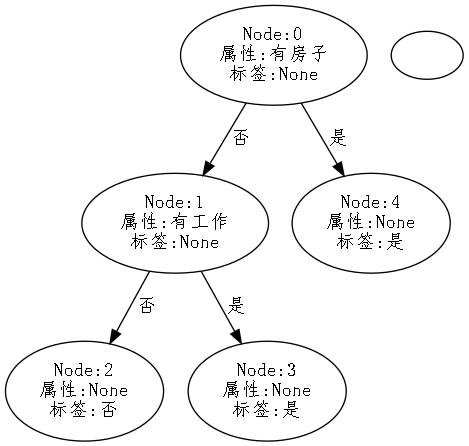

['否', '是', '是', '否', '否', '否', '是', '是', '是', '是', '是', '是', '是', '否']


In [116]:
# 拟合决策树
dt = C45_DTree()
Dtree = dt.fit(train_data)

# 画树的结构
draw(Dtree)
test_data = train_data.iloc[1:16,:-1]

# # 预测结果
y_pred = dt.predict(Dtree,test_data)
print (y_pred)

In [117]:
def info(x, y):
    if x != y and x != 0:
        # 计算当前情况的熵
        return -(x/y)*math.log2(x/y) - ((y-x)/y)*math.log2((y-x)/y)
    if x == y or x == 0:
        # 纯度最大，熵值为0
        return 0


Ent_D = info(5, 15)
print(Ent_D)

# 计算年龄情况的熵
age_small = -(2/5)*math.log2(2/5)-(3/5)*math.log2(3/5)
age_mid = -(3/5)*math.log2(3/5)-(2/5)*math.log2(2/5)
age_big = -(4/5)*math.log2(4/5)-(1/5)*math.log2(1/5)
# 计算年龄特征色信息熵
age_entropy = (5/15)*age_small+(5/15)*age_mid+(5/15)*age_big
# 计算信息增益
Gain_age=Ent_D - age_entropy
print("年龄属性的信息增益: ",Gain_age)

# 计算有工作情况的熵
have_work = 0
not_work = -(4/10)*math.log2(4/10)-(6/10)*math.log2(6/10)
# 计算有工作特征色信息熵
work_entropy = (5/15)*have_work+(10/15)*not_work
# 计算信息增益
Gain_work=Ent_D-work_entropy
print("有工作属性的信息增益: ",Gain_work)

# 计算有房子情况的熵
have_home = 0
not_home = -(3/9)*math.log2(3/9)-(6/9)*math.log2(6/9)
# 计算特征色信息熵
home_entropy = (6/15)*have_home+(9/15)*not_home
# 计算信息增益
Gain_home=Ent_D-home_entropy
print("有房子属性的信息增益: ",Gain_home)

# 计算信用情况的熵
credit_good = -(1/5)*math.log2(1/5)-(4/5)*math.log2(4/5)
credit_better = -(4/6)*math.log2(4/6)-(2/6)*math.log2(2/6)
credit_best = 0
# 计算年龄特征色信息熵
credit_entropy = (5/15)*credit_good+(6/15)*credit_better
# 计算信息增益
Gain_credit=Ent_D - credit_entropy
print(Gain_credit)

0.9182958340544896
年龄属性的信息增益:  0.030352739455589806
有工作属性的信息增益:  0.27099543775137724
有房子属性的信息增益:  0.3673183336217959
0.31033480213690634
